<a href="https://colab.research.google.com/github/ahmetnarman/MNIST-GAN/blob/master/cGAN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN for MNIST dataset

This Jupyter notebook includes a tensorflow implementation of a cGAN model for MNIST dataset. It also includes a softmax MNIST classifier for calculating the inception score of the model.

##  Imporing the required libraries:

This code has numpy, matplotlib and tensorflow dependencies. The MNIST dataset is directly taken from tensorflow datasets. 

If you are using it on Google Colab, they are imported automatically, no need for installing anything.

In [0]:
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17447316609769902823, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16026425850582272838
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9618580421596889397
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14439296812969889905
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

## Functions required by the model

The activation function, the generator model architecture, and the discriminator model architecture are defined here.

In [0]:
# leaky_relu
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

# G(z)
def generator(x, y_label, isTrain=True, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # initializer
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        cat1 = tf.concat([x, y_label], 3)

        # 1st hidden layer
        deconv1 = tf.layers.conv2d_transpose(cat1, 128, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu1 = lrelu(tf.layers.batch_normalization(deconv1, training=isTrain), 0.2)

        # 2nd hidden layer
        deconv2 = tf.layers.conv2d_transpose(lrelu1, 64, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu2 = lrelu(tf.layers.batch_normalization(deconv2, training=isTrain), 0.2)

        # output layer
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 1, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        o = tf.nn.tanh(deconv3)

        return o

# D(x)
def discriminator(x, y_fill, isTrain=True, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # initializer
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        cat1 = tf.concat([x, y_fill], 3)

        # 1st hidden layer
        conv1 = tf.layers.conv2d(cat1, 64, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu1 = lrelu(conv1, 0.2)

        # 2nd hidden layer
        conv2 = tf.layers.conv2d(lrelu1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training=isTrain), 0.2)

        # output layer
        conv3 = tf.layers.conv2d(lrelu2, 1, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=w_init)
        o = tf.nn.sigmoid(conv3)

        return o, conv3

## Visualisation functions

These include functions used to plot generated images and the loss functions.

In [0]:
# show result images 
def show_result(num_epoch, show = True, save = False, path = 'result.png'):
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (img_size, img_size)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        
def show_result_1000(num_epoch, show = True, save = False, path = 'result.png'):    # Display 10 among the 100 images for each class 
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})   # the 10 displayed images are selected every tens (0 10 ... 90)

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        l = k*100
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[l], (img_size, img_size)), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
   
  
def download_images():
    test_images = sess.run(G_z, {z: fixed_z_, y_label: fixed_y_, isTrain: False})
    for k in range(10*1000):
        np.reshape(test_images[k], (img_size, img_size))
    return test_images
        
# training history loss
def show_train_hist(hist, show = True, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

## Preprocessing and preparing for training

Required parameters were assigned. 

In [0]:
img_size = 28
onehot = np.eye(10)
temp_z_ = np.random.normal(0, 1, (1000, 1, 1, 100))    # temp_z_ = np.random.normal(0, 1, (10, 1, 1, 100))
fixed_z_ = temp_z_
fixed_y_ = np.zeros((1000, 1))

for i in range(9):
    fixed_z_ = np.concatenate([fixed_z_, temp_z_], 0)
    temp = np.ones((1000, 1)) + i
    fixed_y_ = np.concatenate([fixed_y_, temp], 0)

fixed_y_ = onehot[fixed_y_.astype(np.int32)].reshape((10000, 1, 1, 10))

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])     # load MNIST data

# training parameters

batch_size = 100
# lr = 0.0002
train_epoch = 30
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(0.0002, global_step, 500, 0.95, staircase=True)

# variables : input

x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, 1))
z = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, 10))
y_fill = tf.placeholder(tf.float32, shape=(None, img_size, img_size, 10))
isTrain = tf.placeholder(dtype=tf.bool)

# networks : generator
G_z = generator(z, y_label, isTrain)

# networks : discriminator
D_real, D_real_logits = discriminator(x, y_fill, isTrain)
D_fake, D_fake_logits = discriminator(G_z, y_fill, isTrain, reuse=True)

# loss for each network
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([batch_size, 1, 1, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([batch_size, 1, 1, 1])))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([batch_size, 1, 1, 1])))

# trainable variables for each network
T_vars = tf.trainable_variables()
D_vars = [var for var in T_vars if var.name.startswith('discriminator')]
G_vars = [var for var in T_vars if var.name.startswith('generator')]

# optimizer for each network

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optim = tf.train.AdamOptimizer(lr, beta1=0.5)
    D_optim = optim.minimize(D_loss, global_step=global_step, var_list=D_vars)
    # D_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(D_loss, var_list=D_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(G_loss, var_list=G_vars)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## Training the cGAN


Number of training image (55000, 28, 28, 1)

Number of training label (55000, 28, 28, 1)

training start!
[1/30] - ptime: 54.78 loss_d: 1.455, loss_g: 1.119


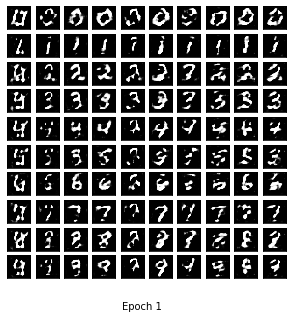

[2/30] - ptime: 52.16 loss_d: 1.346, loss_g: 1.108


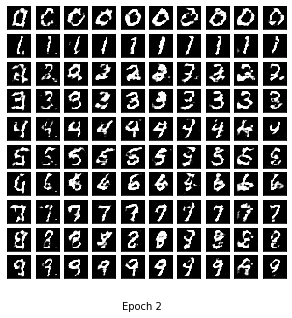

[3/30] - ptime: 52.24 loss_d: 1.184, loss_g: 1.224


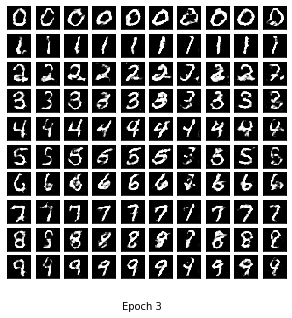

[4/30] - ptime: 51.84 loss_d: 1.354, loss_g: 1.043


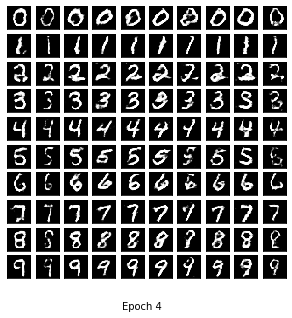

[5/30] - ptime: 51.98 loss_d: 1.375, loss_g: 0.981


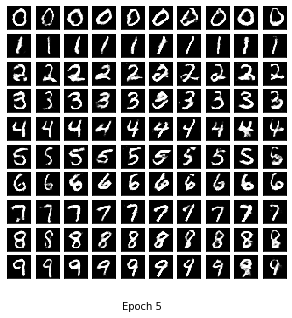

[6/30] - ptime: 51.76 loss_d: 1.297, loss_g: 0.947


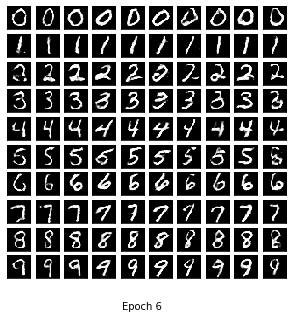

[7/30] - ptime: 52.00 loss_d: 1.226, loss_g: 0.929


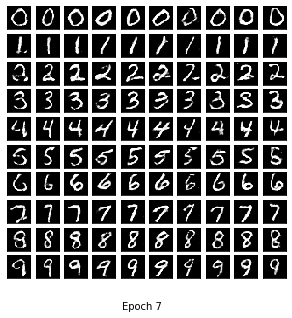

[8/30] - ptime: 51.86 loss_d: 1.142, loss_g: 0.911


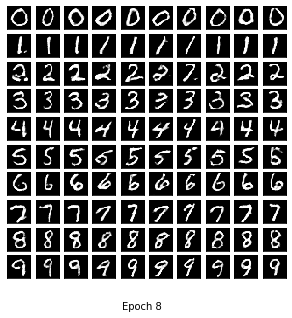

[9/30] - ptime: 52.12 loss_d: 1.095, loss_g: 0.903


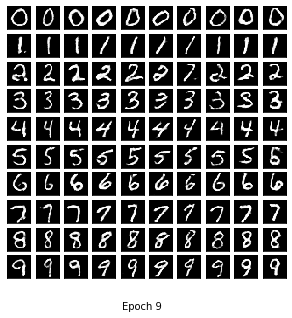

[10/30] - ptime: 51.94 loss_d: 1.073, loss_g: 0.881


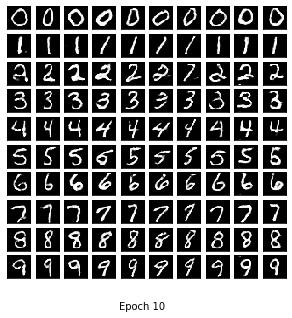

[11/30] - ptime: 52.13 loss_d: 1.041, loss_g: 0.876


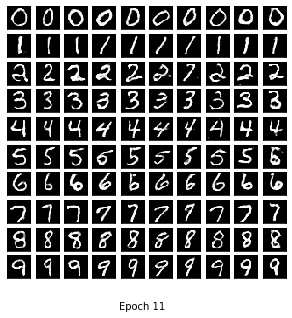

[12/30] - ptime: 52.09 loss_d: 1.028, loss_g: 0.884


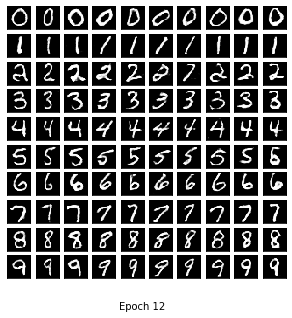

[13/30] - ptime: 52.21 loss_d: 1.022, loss_g: 0.849


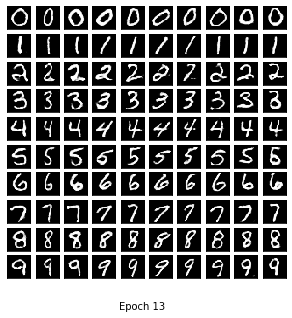

[14/30] - ptime: 52.10 loss_d: 1.004, loss_g: 0.853


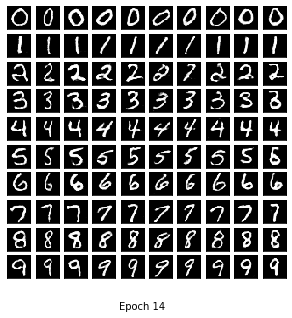

[15/30] - ptime: 52.12 loss_d: 0.998, loss_g: 0.850


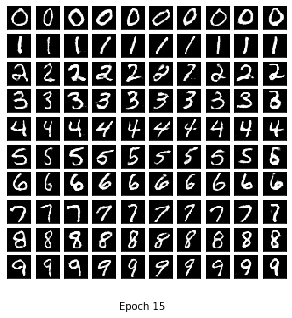

[16/30] - ptime: 52.04 loss_d: 0.986, loss_g: 0.845


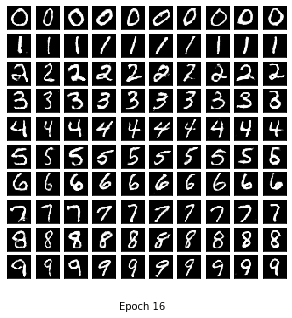

[17/30] - ptime: 52.63 loss_d: 0.986, loss_g: 0.845


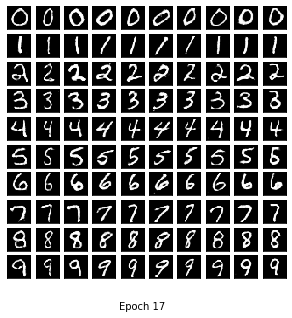

[18/30] - ptime: 52.02 loss_d: 0.974, loss_g: 0.839


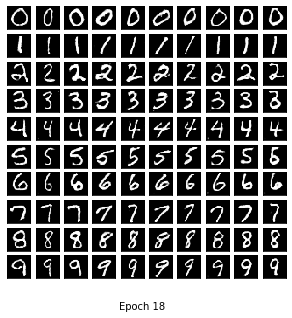

[19/30] - ptime: 52.01 loss_d: 0.965, loss_g: 0.845


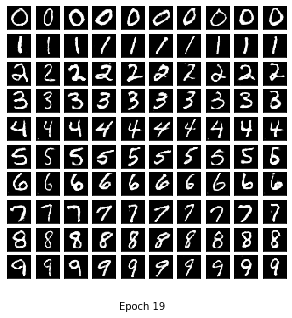

[20/30] - ptime: 52.03 loss_d: 0.962, loss_g: 0.837


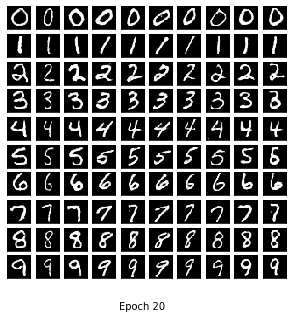

[21/30] - ptime: 52.16 loss_d: 0.947, loss_g: 0.845


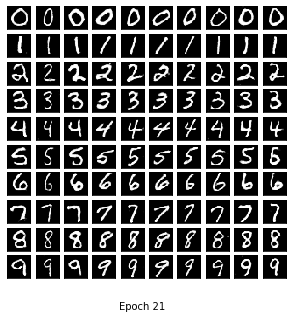

[22/30] - ptime: 51.97 loss_d: 0.937, loss_g: 0.842


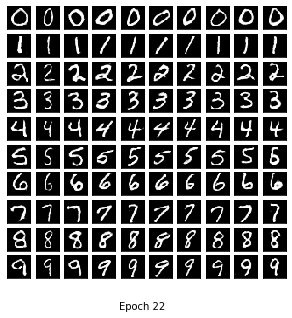

[23/30] - ptime: 52.01 loss_d: 0.937, loss_g: 0.857


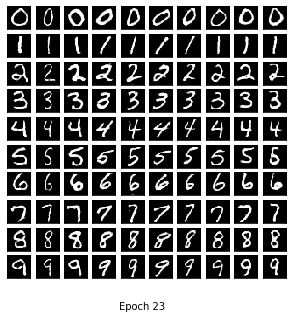

[24/30] - ptime: 51.96 loss_d: 0.943, loss_g: 0.834


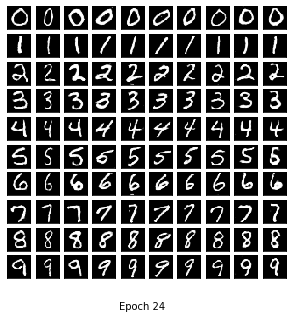

[25/30] - ptime: 52.09 loss_d: 0.922, loss_g: 0.863


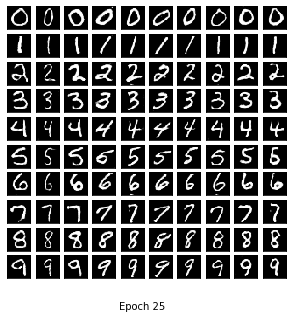

[26/30] - ptime: 52.01 loss_d: 0.937, loss_g: 0.837


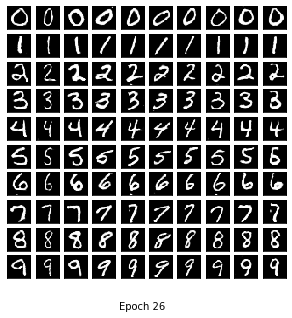

[27/30] - ptime: 52.07 loss_d: 0.921, loss_g: 0.863


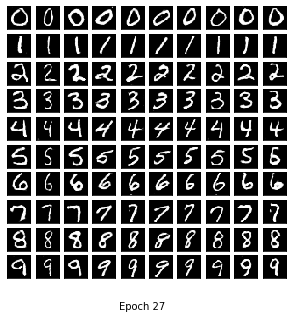

[28/30] - ptime: 52.62 loss_d: 0.912, loss_g: 0.857


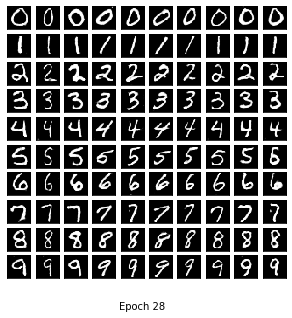

[29/30] - ptime: 52.19 loss_d: 0.912, loss_g: 0.858


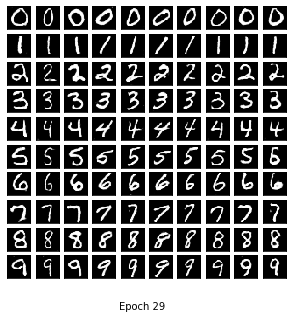

[30/30] - ptime: 52.00 loss_d: 0.901, loss_g: 0.867


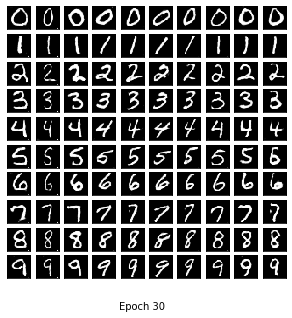

Avg per epoch ptime: 52.17, total 30 epochs ptime: 1751.21
Training finish!... save training results


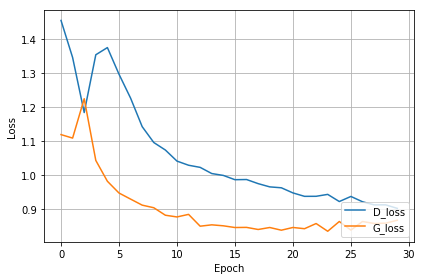

In [0]:
# open session and initialize all variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# MNIST normalization
train_set = (mnist.train.images - 0.5) / 0.5 # Normalization; range (-1,1)
print()
print('Number of training image', train_set.shape)
print()
train_label = mnist.train.labels
print('Number of training label', train_set.shape)
print()


# results save folder
root = 'MNIST_cDCGAN_results/'
model = 'MNIST_cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# training-loop
np.random.seed(int(time.time()))
print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    G_losses = []
    D_losses = []
    epoch_start_time = time.time()
    shuffle_idxs = random.sample(range(0, train_set.shape[0]), train_set.shape[0])
    shuffled_set = train_set[shuffle_idxs]
    shuffled_label = train_label[shuffle_idxs]
    for iter in range(shuffled_set.shape[0] // batch_size):
        # update discriminator
        x_ = shuffled_set[iter*batch_size:(iter+1)*batch_size]
        y_label_ = shuffled_label[iter*batch_size:(iter+1)*batch_size].reshape([batch_size, 1, 1, 10])
        y_fill_ = y_label_ * np.ones([batch_size, img_size, img_size, 10])
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))

        loss_d_, _ = sess.run([D_loss, D_optim], {x: x_, z: z_, y_fill: y_fill_, y_label: y_label_*0.9, isTrain: True})

        # update generator
        z_ = np.random.normal(0, 1, (batch_size, 1, 1, 100))
        y_ = np.random.randint(0, 10, (batch_size, 1))
        y_label_ = onehot[y_.astype(np.int32)].reshape([batch_size, 1, 1, 10])
        y_fill_ = y_label_ * np.ones([batch_size, img_size, img_size, 10])
        loss_g_, _ = sess.run([G_loss, G_optim], {z: z_, x: x_, y_fill: y_fill_, y_label: y_label_, isTrain: True})

        errD_fake = D_loss_fake.eval({z: z_, y_label: y_label_, y_fill: y_fill_, isTrain: False})
        errD_real = D_loss_real.eval({x: x_, y_label: y_label_, y_fill: y_fill_, isTrain: False})
        errG = G_loss.eval({z: z_, y_label: y_label_, y_fill: y_fill_, isTrain: False})

        D_losses.append(errD_fake + errD_real)
        G_losses.append(errG)

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print('[%d/%d] - ptime: %.2f loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, np.mean(D_losses), np.mean(G_losses)))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result_1000((epoch + 1), save=True, path=fixed_p)
    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)
res=download_images()

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)


print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), train_epoch, total_ptime))
print("Training finish!... save training results")
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

## Functions used by the MNIST classifier

These include evaluating the data on the classifier and plotting the sample errors made by the classifier.

In [0]:
# Function for evaluating the model and visualizing results

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    all_predictions = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, predictions = sess.run([accuracy_operation, predictions_operation], feed_dict={x: batch_x, y: batch_y})
        all_predictions = np.hstack((all_predictions, predictions))       # stack predictions to all_predictions list like [all_predictions predictions]
        total_accuracy += (accuracy * len(batch_x))
    all_predictions = np.array(all_predictions)
    return total_accuracy / num_examples, all_predictions
  
def plot_example_errors(y_pred, y_true):
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct_prediction = np.equal(y_pred, y_true)
       
    # Negate the boolean array.
    incorrect = np.equal(correct_prediction, False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = y_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_true[incorrect]
    
    # Plot the first 9 images
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9].astype(np.int))
    
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    img_shape = (32, 32)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


## Training the MNIST classifier, Calculating the inception score

In this part all the required operations for training the classifier is done. Then, the generated  classifier is used to calculate the inception score of the generated images that indicates the performance of the cGAN.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples
Updated Image Shape: (32, 32, 1)
Label of the image is:8
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Training...

EPOCH 1 ...
Validation Accuracy = 0.972

EPOCH 2 ...
Validation Accuracy = 0.978

EPOCH 3 ...
Validation Accuracy = 0.986

EPOCH 4 ...
Validation Accuracy = 0.984

EPOCH 5 ...
Validation Accuracy = 0.985

EPOCH 6 ...
Validation Accuracy = 0.986

EPOCH 7 ...
Validation Accuracy = 0.987

EPOCH 8 ...
Validation Accuracy = 0.985

EPOCH 9 ...
Validation Accuracy = 0.987


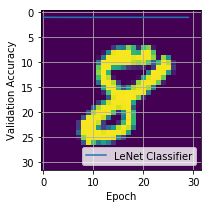

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy on cGAN test set = 0.983
num_correct 980
num_wrong 20
0-class accuracy : 98.00%
num_correct 987
num_wrong 13
1-class accuracy : 98.70%
num_correct 980
num_wrong 20
2-class accuracy : 98.00%
num_correct 980
num_wrong 20
3-class accuracy : 98.00%
num_correct 984
num_wrong 16
4-class accuracy : 98.40%
num_correct 977
num_wrong 23
5-class accuracy : 97.70%
num_correct 983
num_wrong 17
6-class accuracy : 98.30%
num_correct 987
num_wrong 13
7-class accuracy : 98.70%
num_correct 978
num_wrong 22
8-class accuracy : 97.80%
num_correct 986
num_wrong 14
9-class accuracy : 98.60%


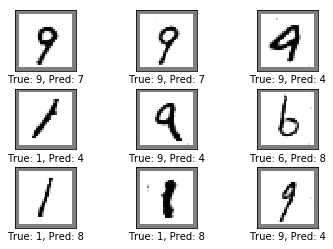

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy on MNIST test set = 0.989


In [0]:
# LOADING AND RESHAPING MNIST DATA for training and validation

mnist = input_data.read_data_sets("MNIST_data/", reshape=False) # importing the data
X_train, y_train           = mnist.train.images, mnist.train.labels # storing training images in X_train and their labels in y_train
X_validation, y_validation = mnist.validation.images, mnist.validation.labels  # storing validation images in X_validation and their labels in y_validation

X_test = res   # storing testing images (generated at the last epoch of training G_z) in X_test and their labels in y_test
y_test=np.zeros((10000,), dtype=int)   # and their labels in y_test
for k in range(10*1000):
        y_test[k]=(k//1000)



# Some verification of the data exctraction
assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

# Converting MNIST images from 28x28x1 to 32x32x1 to feed LeNet nn

import numpy as np
# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')  #np.pad(X,((left_pad_val,right_pad_val),(num_col_l,num_col_r),(num_col_t,num_col_b),(top_pad_val,bottom_pad_val)))
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print("Updated Image Shape: {}".format(X_train[0].shape))

# Visualize data samples

import pdb
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()  # Remove single-dimensional entries from the shape of an array.

plt.figure(figsize=(3,3))
plt.imshow(image)
print("Label of the image is:%d"%y_train[index])

# SHUFFLING DATA so that the NN doesn't exhibit training biases

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# INITIALIZING TENSORFLOW

import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
 
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    conv1 = tf.nn.relu(conv1)                                                                      # Activation
    
    # Layer 2: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')      
    
    # Layer 3: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)                                                                     # Activation

    # Layer 4: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # Layer 5: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # Layer 6: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    fc1 = tf.nn.relu(fc1)                                                                        # Activation

    # Layer 7: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    fc2 = tf.nn.relu(fc2)                                                                        # Activation
    
    # Layer 8: Output Layer. Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits 
  
  
  
x = tf.placeholder(tf.float32, (None, 32, 32, 1))     # x is a placeholder for a batch of input images.
y = tf.placeholder(tf.int32, (None))                  # y is a placeholder for a batch of output labels.
one_hot_y = tf.one_hot(y, 10)                 

rate = 0.001        # Learning rate

logits = LeNet(x)   # Returns predicted label for images fed to LeNet NN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)  # Loss function
loss_operation = tf.reduce_mean(cross_entropy)                                           
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)


predictions_operation = tf.argmax(tf.nn.softmax(logits), 1)                    # Predicted class labels
correct_prediction = tf.equal(predictions_operation, tf.argmax(one_hot_y, 1))  # Number of correctly predicted labels
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))   # Resulting accuracy
saver = tf.train.Saver()


# TRAINING THE MODEL

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    val_acc=[]
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
         
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy, validation_predictions = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        val_acc.append(validation_accuracy)
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

X_test, y_test=shuffle(X_test,y_test)
n_batches=10
batch_size=1000

with tf.Session() as session:
  saver.restore(session,'./lenet')
  logits_=tf.nn.softmax(logits)
  preds=logits_.eval(feed_dict={x: X_test})
  print(preds)
  preds=preds+np.finfo(float).eps
  IS=[]
  for k in range(n_batches):
      p=preds[k * batch_size:(k + 1) * batch_size]
      num_data=p.shape[0]
      #print(p)
      p_y=[]
      p_y=np.sum(p,axis=0)/num_data
      print(p_y)
      Sum=0
      splits=10
      for j in range(splits):
          for i in range(num_data):
              Sum=Sum+preds[i,j]*np.log(preds[i,j]/p_y[j])
      IS.append(np.exp(Sum/batch_size))
      
  print('IS Mean:')
  print(np.mean(IS))
  print('IS Std:')
  print(np.std(IS))
  
def show_train_hist_CNN(hist, show = True, save = False, path = 'Train_hist.png'):
    x = range(len(hist))

    plt.plot(x, hist, label='LeNet Classifier')
   
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

show_train_hist_CNN(val_acc, show = True, save = False, path = 'Train_hist.png')


with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))

    test_accuracy, test_predictions = evaluate(X_test, y_test)
    print("Test Accuracy on cGAN test set = {:.3f}".format(test_accuracy))
    
def accuracy_per_class(c,y_test,y_predictions):
    l_bound=c*1000
    u_bound=l_bound+999
    num_correct=np.count_nonzero(y_test[l_bound:u_bound]==test_predictions[l_bound:u_bound])
    num_wrong=1000-num_correct
    print('num_correct',num_correct)
    print('num_wrong',num_wrong)
    print("{}-class accuracy : {:.2f}%".format(c,num_correct/1000*100))

accuracy_per_class(0,y_test,test_predictions)
accuracy_per_class(1,y_test,test_predictions)
accuracy_per_class(2,y_test,test_predictions)
accuracy_per_class(3,y_test,test_predictions)
accuracy_per_class(4,y_test,test_predictions)
accuracy_per_class(5,y_test,test_predictions)
accuracy_per_class(6,y_test,test_predictions)
accuracy_per_class(7,y_test,test_predictions)
accuracy_per_class(8,y_test,test_predictions)
accuracy_per_class(9,y_test,test_predictions)

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    img_shape = (32, 32)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_example_errors(y_pred, y_true):
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct_prediction = np.equal(y_pred, y_true)
       
    # Negate the boolean array.
    incorrect = np.equal(correct_prediction, False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = y_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_true[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9].astype(np.int))

plot_example_errors(test_predictions, y_test)

X_test_MNIST, y_test_MNIST            = mnist.test.images, mnist.test.labels   # storing testing images in X_test and their labels in y_test
X_test_MNIST      = np.pad(X_test_MNIST, ((0,0),(2,2),(2,2),(0,0)), 'constant')

with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('.'))

    test_accuracy, test_predictions = evaluate(X_test_MNIST, y_test_MNIST)
    print("Test Accuracy on MNIST test set = {:.3f}".format(test_accuracy))


In [0]:
X_test, y_test = mnist.test.images, mnist.test.labels
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

X_test, y_test=shuffle(X_test,y_test)
n_batches=10
batch_size=1000

with tf.Session() as session:
  saver.restore(session,'./lenet')
  logits_=tf.nn.softmax(logits)
  preds=logits_.eval(feed_dict={x: X_test})
  print(preds)
  preds=preds+np.finfo(float).eps
  IS=[]
  for k in range(n_batches):
      p=preds[k * batch_size:(k + 1) * batch_size]
      num_data=p.shape[0]
      #print(p)
      p_y=[]
      p_y=np.sum(p,axis=0)/num_data
      print(p_y)
      Sum=0
      splits=10
      for j in range(splits):
          for i in range(num_data):
              Sum=Sum+preds[i,j]*np.log(preds[i,j]/p_y[j])
      IS.append(np.exp(Sum/batch_size))
      
  print('IS Mean:')
  print(np.mean(IS))
  print('IS Std:')
  print(np.std(IS))

INFO:tensorflow:Restoring parameters from ./lenet
[[1.2862537e-11 3.3792035e-11 1.5472402e-17 ... 5.8724704e-22
  1.4940062e-10 1.2425420e-15]
 [1.0000000e+00 2.7577281e-13 2.0148208e-09 ... 7.8188510e-15
  6.3327476e-14 1.0099731e-08]
 [3.7804348e-20 4.8128679e-22 1.7286313e-13 ... 2.9070695e-09
  2.1036811e-11 1.0000000e+00]
 ...
 [2.2357758e-30 3.9724523e-29 4.0725421e-28 ... 8.2185336e-30
  1.5259226e-16 5.9723839e-14]
 [1.7041563e-14 2.6281061e-10 1.1910853e-09 ... 2.3411434e-11
  5.4935132e-14 2.5505816e-11]
 [1.1676431e-15 1.7303597e-13 3.4106748e-10 ... 2.2380020e-08
  5.0850707e-10 9.9999988e-01]]
[0.08896392 0.11629301 0.1058435  0.11738486 0.07856213 0.0870611
 0.10756042 0.09559253 0.11072567 0.09201281]
[0.09573982 0.1118476  0.11105182 0.08602539 0.10065328 0.09990747
 0.09197327 0.10914513 0.09214629 0.10150985]
[0.09341496 0.11775954 0.08701853 0.09789285 0.10371374 0.08664572
 0.1071445  0.10280238 0.08808076 0.11552694]
[0.10795335 0.10298278 0.08875003 0.10871719 0.1